<a href="https://colab.research.google.com/github/Chan0226/MNIST-project/blob/main/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 확율 생성모델을 MNIST 필기 숫자에 적용하기

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

#mnist 데이터를 읽고 0 패턴만 추출
(x_train,y_train),(x_test,y_test) =  mnist.load_data()

In [ ]:
# 확율 생성모델 구축 ( 화소 수준)
P = np.zeros((28,28,256))
#화소별로 0~255사이의 명암값의 빈도를 P에 저장
for k in range(X.shape[0]):
  for i in range(X.shape[1]):
    for j in range(X.shape[2]):
      P[i][j][X[k][i][j]] += 1
P = P/X.shape[0]      


In [ ]:
# 확율 생성모델 이용해서 20개의 샘플을 생성
Xnew = np.zeros((20,28,28))
for i in range(20):
  for r in range(28):
    for c in range(28):
      Xnew[i][r][c] = np.random.choice(range(256),p=P[r][c])

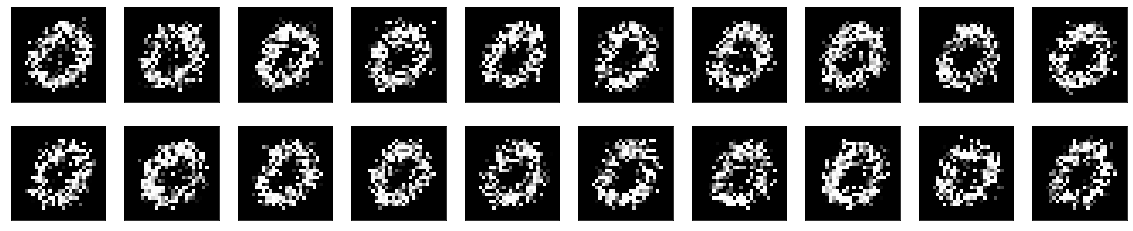

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for r in range(2):
  for c in range(10):
    plt.subplot(2,10,r*10+c+1)
    plt.imshow(Xnew[r*10+c], cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()    


## mnist를 이용한 오토 인코더 구현

In [ ]:
import numpy as  np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [ ]:
# 데이터를 가져와서 신경망에 입력할수 있는 형태로 변환
(x_train,y_train),(x_test,y_test) =  mnist.load_data()
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train[:1]

In [ ]:
x_train =  np.reshape(x_train,(len(x_train),28,28,1))
x_test =  np.reshape(x_test,(len(x_test),28,28,1))
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# 잠복공간의 차원
zdim = 32

In [ ]:
# 오토인코더의 인코더 설계  C-C-C-C-FC
encoder_input = Input(shape=(28,28,1))
# model.add(Conv2D(....))  --> Sequential 방식
x = Conv2D(32,(3,3),activation='relu', padding='same',strides=(1,1))(encoder_input)  #Funtional API
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Flatten()(x)
encoder_output = Dense(zdim)(x)
model_encoder = Model(encoder_input,encoder_output)
model_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                1003

In [ ]:
# 디코더 설계
decoder_input = Input(shape = (zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x = Conv2DTranspose(64,(3,3), activation='relu',padding='same',strides=(1,1))(x)
x = Conv2DTranspose(64,(3,3), activation='relu',padding='same',strides=(2,2))(x)
x = Conv2DTranspose(32,(3,3), activation='relu',padding='same',strides=(2,2))(x)
x = Conv2DTranspose(1,(3,3), activation='relu',padding='same',strides=(1,1))(x)
decoder_output = x
model_decoder = Model(decoder_input,decoder_output)
model_decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              103488    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       1846

In [ ]:
# 인코더와 디코더를 결합해서 오토인코더 모델 구축
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input, model_output)

In [ ]:
x_test.shape, 

In [ ]:
# 인코더 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/5
469/469 [==============================] - 16s 33ms/step - loss: 0.0223 - val_loss: 0.0065
Epoch 2/5
469/469 [==============================] - 15s 32ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 3/5
469/469 [==============================] - 15s 32ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/5
469/469 [==============================] - 15s 32ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 5/5
469/469 [==============================] - 15s 32ms/step - loss: 0.0038 - val_loss: 0.0037


In [ ]:
# 복원 실험 1: x_test를 복원하는 예측 실험
decoded_img=model.predict(x_test)

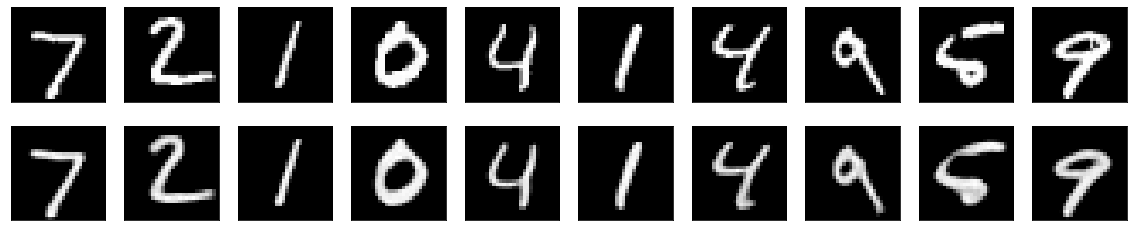

In [ ]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  plt.subplot(2,n,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.subplot(2,n,i + n +1)
  plt.imshow(decoded_img[i].reshape(28,28), cmap='gray')
  plt.xticks([]); plt.yticks([])
plt.show()  

In [ ]:
# 학습된 오토인코더를 생성 모델로 활용

In [ ]:
x0 = x_test[0]
z = model_encoder.predict(x0.reshape(1,28,28,1))
print(np.round(z,3))
zz = np.zeros((20,zdim))
for i in range(20):
  zz[i] = z[0]+(i-10)/10.0   # 0~1  0.1씩 잡음을 넣음
generated_image = model_decoder.predict(zz)

[[-1.601  0.238 -0.461  0.047  1.416  0.949  0.515 -0.225  0.311  0.13
   0.88   0.274  0.183  0.504 -0.061  0.266 -0.263  0.429 -0.551  0.752
  -1.975  0.43   1.906 -0.926 -0.523  0.21   0.876 -0.481  0.17  -1.217
   0.798  1.471]]


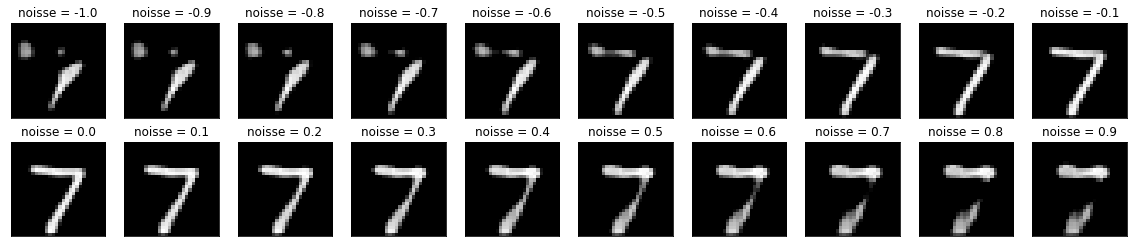

In [ ]:
plt.figure(figsize=(20,4))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.imshow(generated_image[i].reshape(28,28),cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.title('noisse = '+str((i-10)/10.0))
plt.show()  

In [ ]:
# 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성
x4_6 = np.array((x_test[4],x_test[6]))
z = model_encoder.predict(x4_6)
zz = np.zeros((20,zdim))
for i in range(20):
  alpha = i/(20.0-1.0)
  zz[i] = (1.0-alpha)*z[0]+alpha*z[1]
generated_image = model_decoder.predict(zz)  

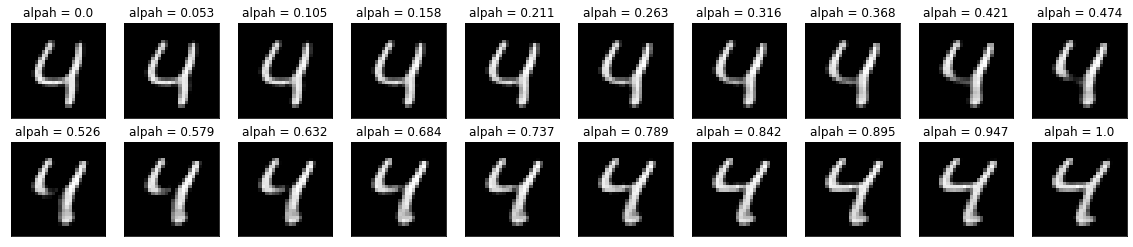

In [ ]:
plt.figure(figsize=(20,4))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.imshow(generated_image[i].reshape(28,28),cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.title('alpah = '+str(  round(i/(20.0-1.0),3 )))
plt.show()  

## 잠복공간 zdim 관찰  좋은 품질의 셈플을 얻기위해서 

In [ ]:

import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

(x_train,y_train),(x_test,y_test) =  mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train =  np.reshape(x_train,(len(x_train),28,28,1))
x_test =  np.reshape(x_test,(len(x_test),28,28,1))

In [ ]:
zdim = 2 # 시각화를 위해서

In [ ]:
# 인코더 설계
encoder_input = Input(shape=(28,28,1))
# model.add(Conv2D(....))  --> Sequential 방식
x = Conv2D(32,(3,3),activation='relu', padding='same',strides=(1,1))(encoder_input)  #Funtional API
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Flatten()(x)
encoder_output = Dense(zdim)(x)
model_encoder = Model(encoder_input,encoder_output)

In [ ]:
# 디코더 설계
decoder_input = Input(shape = (zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x = Conv2DTranspose(64,(3,3), activation='relu',padding='same',strides=(1,1))(x)
x = Conv2DTranspose(64,(3,3), activation='relu',padding='same',strides=(2,2))(x)
x = Conv2DTranspose(32,(3,3), activation='relu',padding='same',strides=(2,2))(x)
x = Conv2DTranspose(1,(3,3), activation='relu',padding='same',strides=(1,1))(x)
decoder_output = x
model_decoder = Model(decoder_input,decoder_output)

In [ ]:
# 인코더 + 디코더 모델 구축
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input,model_output)

In [ ]:
# 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,
          shuffle=True,validation_data=(x_test,x_test))
decoded_img = model.predict(x_test)

Epoch 1/5
469/469 [==============================] - 18s 33ms/step - loss: 0.0545 - val_loss: 0.0470
Epoch 2/5
469/469 [==============================] - 15s 32ms/step - loss: 0.0446 - val_loss: 0.0436
Epoch 3/5
469/469 [==============================] - 15s 31ms/step - loss: 0.0423 - val_loss: 0.0415
Epoch 4/5
469/469 [==============================] - 15s 31ms/step - loss: 0.0412 - val_loss: 0.0418
Epoch 5/5
469/469 [==============================] - 15s 31ms/step - loss: 0.0404 - val_loss: 0.0407


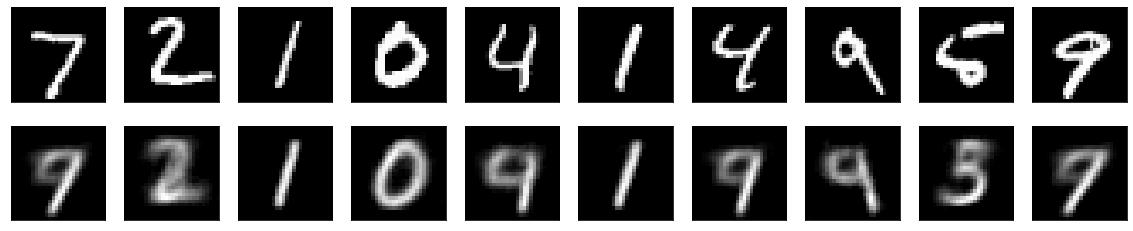

In [ ]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  plt.subplot(2,n,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap='gray')
  plt.xticks([]); plt.yticks([])
  plt.subplot(2,n,i + n +1)
  plt.imshow(decoded_img[i].reshape(28,28), cmap='gray')
  plt.xticks([]); plt.yticks([])
plt.show()  

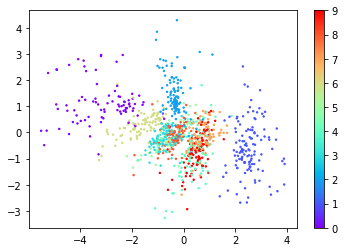

In [ ]:
# 테스트 집합의 분포를 2차원 잠복 공간에 시각화
n=1000
xx=x_test[0:n]
z=model_encoder.predict(xx)
sc=plt.scatter(z[:,0],z[:,1],s=2,c=y_test[0:n],cmap='rainbow')
plt.colorbar(sc)